In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, classification_report

In [2]:
def split_data(Xs,y,test_size=0.2, seed=42):
    return train_test_split(Xs,y,test_size=test_size,random_state=seed)

In [3]:
df = pd.read_csv('Real_Estate_Listings.csv')
df.shape

(1185, 107)

## Modeling Pipeline

In [4]:
np.random.seed(13422)
test_df = df[df['ListType']=='For Sale'].sample(100)
train_df = df.drop(test_df.index)
test_df.shape,train_df.shape

((100, 107), (1085, 107))

In [5]:
y_price = train_df['Price']
y_listtype = np.where(train_df['ListType']=='Sold',1,0)

Price Modeling

In [6]:
Xs = train_df.drop(columns=['Price','ListType','Street','Tax Assessed Value']).fillna(0)
X_train, X_valid, y_train, y_valid = split_data(Xs,y_price)
X_train.shape, X_valid.shape

((868, 103), (217, 103))

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
preds = lin_reg.predict(X_valid)
r2_score(y_valid,preds), mean_squared_error(y_valid,preds)

(0.8584961543876728, 10290572452.564112)

Acquisition Modeling

In [8]:
Xs = train_df.drop(columns=['Price','ListType','Street']).fillna(0)
X_train, X_valid, y_train, y_valid = split_data(Xs,y_listtype)
X_train.shape, X_valid.shape

((868, 104), (217, 104))

In [9]:
log_reg = LogisticRegression(random_state=23)
log_reg.fit(X_train,y_train)
preds = log_reg.predict(X_valid)
print(classification_report(y_valid,preds))

              precision    recall  f1-score   support

           0       0.62      0.95      0.75       132
           1       0.54      0.08      0.14        85

    accuracy                           0.61       217
   macro avg       0.58      0.52      0.45       217
weighted avg       0.59      0.61      0.51       217



Property Clustering

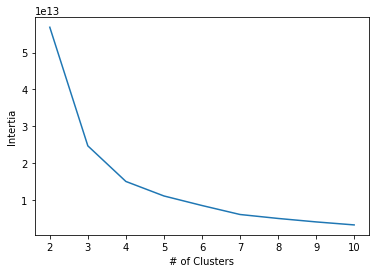

In [10]:
Xs = train_df.drop(columns=['ListType','Street']).fillna(0)

metric = []
for num_clusters in list(range(1,10)):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(Xs)
    metric.append(kmeans.inertia_)

plt.plot(range(2,len(metric)+2),metric)
plt.ylabel('Intertia')
plt.xlabel('# of Clusters')
plt.show()

In [11]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(Xs)
pd.Series(kmeans.labels_).value_counts()

1    700
3    328
2     44
0     13
dtype: int64

### Model Explainability

In [12]:
Xs = train_df.drop(columns=['Price','ListType','Street','Tax Assessed Value']).fillna(0)

feat_coef = pd.DataFrame(Xs.columns,columns=['Feature'])
feat_coef = feat_coef.set_index('Feature')
feat_coef['Coefficient'] = lin_reg.coef_
feat_coef.sort_values('Coefficient',ascending=False).head(5)

,Coefficient
Feature,
Heating: Electric,177077.163744
Lon,155049.166422
Type: Apartment,79796.872623
Roof: Built up,57192.678575
Flooring: Slate,51594.945511


In [13]:
Xs = train_df.drop(columns=['Price','ListType','Street']).fillna(0)
feat_coef = pd.DataFrame(Xs.columns,columns=['Feature'])
feat_coef = feat_coef.set_index('Feature')
feat_coef['Coefficient'] = log_reg.coef_[0]
feat_coef.sort_values('Coefficient',ascending=False).head(5)

,Coefficient
Feature,
Total Interior Livable Area,0.001327
Full Bathrooms,0.000056
Roof: Asphalt,0.000050
Stories,0.000041
Flooring: Hardwood,0.000040


In [14]:
Xs = train_df.drop(columns=['ListType','Street']).fillna(0)
cluster_centers = pd.DataFrame(kmeans.cluster_centers_,columns=Xs.columns)
cols = ['Price','Beds','Baths','Area','Stories','Beds','Baths']

cluster_centers[cols].T

,0,1,2,3
Price,1.675385e+06,89416.051429,594911.659091,215824.984756
Beds,5.076923e+00,3.068571,3.295455,3.378049
Baths,3.000000e+00,1.448571,2.556818,2.306402
Area,2.706462e+03,1537.531429,3136.272727,2310.591463
Stories,2.000000e+00,1.197143,1.659091,1.701220
Beds,5.076923e+00,3.068571,3.295455,3.378049
Baths,3.000000e+00,1.448571,2.556818,2.306402


### Ranking Algorithm

In [15]:
clusters = train_df.loc[:,['ListType']]
clusters['cluster'] = kmeans.labels_

def calculate_sold_probab(df):
    sold_probab = {}
    for cluster in sorted(df['cluster'].unique()):
        ith_cluster = df['cluster']==cluster
        subset = df[ith_cluster]
        is_sold = subset['ListType']=='Sold'
        print(cluster,len(subset[is_sold])/len(subset))
        sold_probab[cluster] = len(subset[is_sold])/len(subset)
    return sold_probab

sold_probab_cluster = calculate_sold_probab(clusters)
sold_probab_cluster

0 0.0
1 0.42714285714285716
2 0.1590909090909091
3 0.4451219512195122


{0: 0.0, 1: 0.42714285714285716, 2: 0.1590909090909091, 3: 0.4451219512195122}

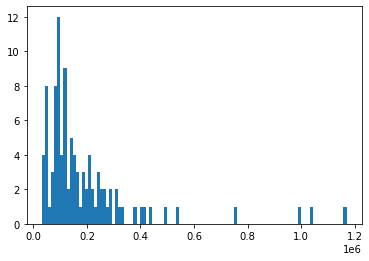

In [16]:
#pricing
Xs = test_df.drop(columns=['Price','ListType','Street','Tax Assessed Value']).fillna(0)
predicted_price = lin_reg.predict(Xs)
plt.hist(predicted_price,bins=100);

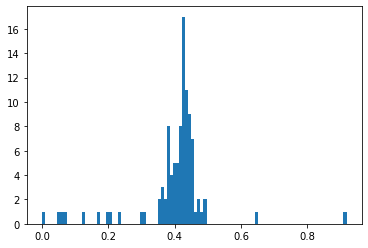

In [17]:
#acquisition
Xs = test_df.drop(columns=['Price','ListType','Street']).fillna(0)
acquisition_probability = log_reg.predict_proba(Xs)
plt.hist(acquisition_probability[:,1],bins=100);

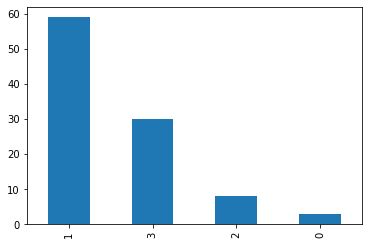

In [18]:
#cluster
Xs = test_df.drop(columns=['ListType','Street']).fillna(0)
property_clusters = kmeans.predict(Xs)
pd.Series(property_clusters).value_counts().plot.bar()

In [19]:
results = pd.read_csv('Key.csv')
results = results.loc[test_df.index,['URL','Price']].reset_index(drop=True)

budget = 1e6 # $1M 

results['PriceEstRank'] = (results['Price']-pd.Series(predicted_price)).rank()
results['BudgetRank'] = (results['Price']-[budget]*len(results)).rank()
results['SoldRank'] = pd.Series(acquisition_probability[:,1]).rank()
results['ClusterRank'] = pd.Series(property_clusters).map(sold_probab_cluster).rank()

results['OverallRank'] = results[['PriceEstRank','SoldRank','ClusterRank','BudgetRank']].mean(axis=1).rank()
results = results.sort_values(['OverallRank'],ascending=True)

results.to_csv('Recommendations.csv',index=False)
results.head(10)

,URL,Price,PriceEstRank,BudgetRank,SoldRank,ClusterRank,OverallRank
45,https://www.zillow.com/homedetails/205-Westage...,79900.0,9.0,27.0,24.0,41.0,1.0
4,https://www.zillow.com/homedetails/103-Marion-...,795000.0,1.0,95.5,3.0,7.5,2.0
99,https://www.zillow.com/homedetails/820-Eastbro...,119903.0,11.0,44.0,13.0,41.0,3.5
88,https://www.zillow.com/homedetails/76-Oriole-S...,795000.0,2.0,95.5,4.0,7.5,3.5
95,https://www.zillow.com/homedetails/1048-N-Clin...,70000.0,3.0,24.0,60.0,41.0,5.0
56,https://www.zillow.com/homedetails/61-Weaver-S...,57900.0,13.0,17.0,67.0,41.0,6.0
35,https://www.zillow.com/homedetails/967-Cliffor...,54900.0,12.0,13.5,72.0,41.0,7.0
66,https://www.zillow.com/homedetails/39-Locust-S...,9900.0,5.0,1.0,92.0,41.0,8.0
71,https://www.zillow.com/homedetails/163-Merrill...,94811.0,35.0,36.0,32.0,41.0,9.5
27,https://www.zillow.com/homedetails/48-Kramer-S...,133000.0,14.0,55.0,34.0,41.0,9.5
